<a href="https://colab.research.google.com/github/thingkilia2507/PTCJNN_BangkitCapstoneProject/blob/celine-branch/Machine%20Learning/notebooks/Hate%20Speech%20Detection%20-%20ALBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Acknowledgment**

This notebook mainly use codes from https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py and modified accordingly.
```
#!/usr/bin/env python
# coding=utf-8
# Copyright 2021 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Fine-tuning the library models for sequence classification."""
# You can also adapt this script on your own text classification task. Pointers for this are left as comments.
```


**Other References**
* https://towardsdatascience.com/tensorflow-and-transformers-df6fceaf57cc
* https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a


**Pre-trained Language Model: ```indobenchmark/indobert-lite-base-p1``` from:**
```
@inproceedings{wilie2020indonlu,
  title={IndoNLU: Benchmark and Resources for Evaluating Indonesian Natural Language Understanding},
  author={Bryan Wilie and Karissa Vincentio and Genta Indra Winata and Samuel Cahyawijaya and X. Li and Zhi Yuan Lim and S. Soleman and R. Mahendra and Pascale Fung and Syafri Bahar and A. Purwarianti},
  booktitle={Proceedings of the 1st Conference of the Asia-Pacific Chapter of the Association for Computational Linguistics and the 10th International Joint Conference on Natural Language Processing},
  year={2020}
}
```

# **Library**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PROJECT_ROOT = 'drive/My Drive/Bangkit Capstone PT CJNN/ML/'
HS_PATH = PROJECT_ROOT + 'dataset/hate_speech/'

Mounted at /content/drive
time: 15.1 s (started: 2021-05-16 15:56:00 +00:00)


In [1]:
!pip install --upgrade transformers
!pip install simpletransformers
!pip install ipython-autotime
%load_ext autotime

import os, sys
import logging
import json
import re
import time
import pandas as pd
import numpy as np
import tensorflow as tf

from functools import partial
from datetime import timedelta
from datasets import load_dataset
from matplotlib import pyplot as plt
from transformers import AlbertConfig, BertTokenizer, TFAlbertForSequenceClassification, TFTrainingArguments, set_seed
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report

Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.6.0)
time: 2.53 s (started: 2021-05-16 15:55:53 +00:00)


In [ ]:
from transformers.file_utils import CONFIG_NAME, TF2_WEIGHTS_NAME
print(CONFIG_NAME)
print(TF2_WEIGHTS_NAME)

config.json
tf_model.h5
time: 2.8 ms (started: 2021-05-14 11:28:35 +00:00)


# **SETTINGS**

In [3]:
train_df = pd.read_csv(HS_PATH + 'train.csv')
val_df = pd.read_csv(HS_PATH + 'val.csv')
test_df = pd.read_csv(HS_PATH + 'test.csv')

measurer = np.vectorize(len)
max_seq_len_train = measurer(train_df['sentence1'].values.astype(str)).max(axis=0)
max_seq_len_val = measurer(val_df['sentence1'].values.astype(str)).max(axis=0)
max_seq_len_test = measurer(test_df['sentence1'].values.astype(str)).max(axis=0)

print('Maximum sequence length in training data'.ljust(42), ':', max_seq_len_train)
print('Maximum sequence length in validation data'.ljust(42), ':', max_seq_len_val)
print('Maximum sequence length in testing data'.ljust(42), ':', max_seq_len_test)

Maximum sequence length in training data   : 1209
Maximum sequence length in validation data : 580
Maximum sequence length in testing data    : 617
time: 2.14 s (started: 2021-05-16 15:56:20 +00:00)


In [4]:
PRETRAINED_MODEL = 'indobenchmark/indobert-lite-base-p1'
LABEL2ID =  {'non_hs':0, 'hs': 1}
MAX_SEQ_LEN = np.max([max_seq_len_train, max_seq_len_val, max_seq_len_test])

time: 1.59 ms (started: 2021-05-16 15:56:22 +00:00)


# **Helper Function**

In [5]:
def preprocess_function(data, tokenizer, non_label_column_names):
    # Tokenize the texts
    args = (data['sentence1'],) if 'sentence2' not in non_label_column_names else (data['sentence1'], data['sentence2'])
    result = tokenizer(*args, max_length=MAX_SEQ_LEN, truncation=True, padding=True,
                                add_special_tokens=True, return_attention_mask=True, return_token_type_ids=True)

    # Map labels to IDs
    if LABEL2ID is not None and 'label' in data:
        result['label'] = [LABEL2ID[l] for l in data['label']]
    return result

time: 5.56 ms (started: 2021-05-16 15:57:25 +00:00)


In [6]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    # Hugging Face models have a save_pretrained() method that saves both the weights and the necessary
    # metadata to allow them to be loaded as a pretrained model in future. This is a simple Keras callback
    # that saves the model with this method after each epoch.
    def __init__(self, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        self.model.save_pretrained(self.output_dir)

time: 12.2 ms (started: 2021-05-16 15:57:27 +00:00)


In [7]:
def convert_dataset_for_tensorflow(
    dataset, non_label_column_names, batch_size, dataset_mode='variable_batch', shuffle=True, drop_remainder=True
):
    '''
      Converts a Hugging Face dataset to a Tensorflow Dataset. The dataset_mode controls whether we pad all batches
      to the maximum sequence length, or whether we only pad to the maximum length within that batch. The former
      is most useful when training on TPU, as a new graph compilation is required for each sequence length.
    '''

    def densify_ragged_batch(features, label=None):
        features = {
            feature: ragged_tensor.to_tensor(shape=batch_shape[feature]) for feature, ragged_tensor in features.items()
        }
        if label is None:
            return features
        else:
            return features, label

    feature_keys = list(set(dataset.features.keys()) - set(non_label_column_names + ['label'])) # only take the tokenized embeddings
    if dataset_mode == 'variable_batch':
        batch_shape = {key: None for key in feature_keys}
        data = {key: tf.ragged.constant(dataset[key]) for key in feature_keys}
    elif dataset_mode == 'constant_batch':
        data = {key: tf.ragged.constant(dataset[key]) for key in feature_keys}
        batch_shape = {
            key: tf.concat(([batch_size], ragged_tensor.bounding_shape()[1:]), axis=0)
            for key, ragged_tensor in data.items()
        }
    else:
        raise ValueError('Unknown dataset mode!')

    if 'label' in dataset.features:
        labels = tf.convert_to_tensor(np.array(dataset['label']))
        tf_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    else:
        tf_dataset = tf.data.Dataset.from_tensor_slices(data)
    
    if shuffle:
        tf_dataset = tf_dataset.shuffle(buffer_size=len(dataset))
    
    tf_dataset = tf_dataset.batch(batch_size=batch_size, drop_remainder=drop_remainder).map(densify_ragged_batch)
    return tf_dataset

time: 24.4 ms (started: 2021-05-16 15:57:28 +00:00)


In [8]:
def classification_metrics(list_true, list_preds):
    metrics = {}
    metrics['ACC'] = accuracy_score(list_true, list_preds)
    metrics['F1'] = f1_score(list_true, list_preds, average='weighted')
    metrics['REC'] = recall_score(list_true, list_preds, average='weighted')
    metrics['PRE'] = precision_score(list_true, list_preds, average='weighted')
    return metrics

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append(f'\033[1m{key}:\033[0m{value:.4f}')
    return ' '.join(string_list)

time: 8.22 ms (started: 2021-05-16 15:57:30 +00:00)


In [9]:
def plot_history(history):
    epochs = range(1, len(history['val_loss']) + 1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    axes[0].set_title('Training and Validation Loss')
    axes[0].plot(epochs, history['val_loss'], label='val loss')
    axes[0].plot(epochs, history['loss'], label='train loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='best')

    axes[1].set_title('Training and Validation Accuracy')
    axes[1].plot(epochs, history['val_accuracy'], label='val accuracy')
    axes[1].plot(epochs, history['accuracy'], label='train accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='best')

time: 7.46 ms (started: 2021-05-16 15:57:31 +00:00)


In [10]:
def main(datasets, training_args, config, non_label_column_names, PRETRAINED_MODEL=PRETRAINED_MODEL):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Reduce the amount of console output from TF
    logger = logging.getLogger(__name__)


    with training_args.strategy.scope():
        set_seed(training_args.seed)

        model = TFAlbertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, config=config)

        optimizer = tf.keras.optimizers.Adam(
                learning_rate=training_args.learning_rate,
                clipnorm=training_args.max_grad_norm,
            )
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        acc = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
        model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

        # Convert data to TF format
        # Convert data to a tf.keras.utils.Sequence object for training if we're not using a TPU
        # For TPU, convert to a tf.data.Dataset
        tf_data = dict()
        for key in ('train', 'validation', 'test'):
            if key == 'train':
                shuffle = True
                batch_size = training_args.per_device_train_batch_size
                drop_remainder = True  # Saves us worrying about scaling gradients for the last batch
            else:
                shuffle = False
                batch_size = training_args.per_device_eval_batch_size
                drop_remainder = False

            dataset = datasets[key]
            if isinstance(training_args.strategy, tf.distribute.TPUStrategy):
                logger.info("Padding all batches to max length because argument was set or we're on TPU.")
                dataset_mode = 'constant_batch'
            else:
                dataset_mode = 'variable_batch'

            data = convert_dataset_for_tensorflow(
                dataset,
                non_label_column_names,
                batch_size=batch_size,
                dataset_mode=dataset_mode,
                drop_remainder=drop_remainder,
                shuffle=shuffle,
            )
            tf_data[key] = data

        # Training and validation
        training_start_time = time.time()
        history = None
        if tf_data['train'] is not None and training_args.do_train:
            callbacks = [SavePretrainedCallback(output_dir=training_args.output_dir),
                         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
            history = model.fit(
                      tf_data['train'],
                      validation_data=tf_data['validation'],
                      epochs=int(training_args.num_train_epochs),
                      callbacks=callbacks,
            )
        elif tf_data['validation'] is not None and training_args.do_eval:
            # If there's a validation dataset but no training set, just evaluate the metrics
            logger.info('Computing metrics on validation data...')
            loss, acc = model.evaluate(tf_data['validation'])
            logger.info(f'Loss: {loss:.5f}, Accuracy: {acc * 100:.4f}%')

        finished = time.time() - training_start_time
        finished = str(timedelta(seconds=finished))

        # Prediction
        if tf_data['test'] is not None and training_args.do_predict:
            logger.info('Doing predictions on test dataset...')
            predictions = model.predict(tf_data['test'])['logits']
            predicted_class_idx = np.argmax(predictions, axis=1)
            predicted_class_name = [config.id2label[idx] for idx in predicted_class_idx]
            output_test_file = os.path.join(training_args.output_dir, 'test_preds.csv')
            pd.DataFrame(predicted_class_name, columns=['prediction']).to_csv(output_test_file)
            logger.info(f'Wrote predictions to {output_test_file}!')

    # region Prediction losses
    # This section is outside the scope() because it's very quick to compute, but behaves badly inside it
    if 'test' in datasets and 'label' in datasets['test'].features and training_args.do_predict:
        print('\n')
        print(' \033[1mMODEL PERFORMANCE ON TEST SET\033[0m '.center(100, '='))
        labels_idx = datasets['test']['label']
        labels_name = [config.id2label[idx] for idx in labels_idx]
        loss = float(loss(labels_idx, predictions).numpy())
        print(f'\033[1mLoss\033[0m:{loss:.4f}', metrics_to_string(classification_metrics(labels_idx, predicted_class_idx)))
        print('\n\033[1mClassification Report:\033[0m')
        print(classification_report(labels_name, predicted_class_name))    
    # endregion

    if tf_data['train'] is not None and training_args.do_train:
        print('\n')
        print(' \033[1mTRAINING AND VALIDATION PERFORMANCE\033[0m '.center(100, '='))
        print('\033[1mTotal Training and Validation Time:\033[0m', finished)
        print('\n\033[1mPerformance Over Epochs:\033[0m')
        plot_history(history.history)

    return history

time: 102 ms (started: 2021-05-16 15:57:33 +00:00)


# **Load Pretrained Tokenizer and Configuration**

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL, do_lower_case=True)
tokenizer

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='indobenchmark/indobert-lite-base-p1', vocab_size=29999, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

time: 295 ms (started: 2021-05-16 15:58:53 +00:00)


In [14]:
# Configuration
config_ori = AlbertConfig.from_pretrained(PRETRAINED_MODEL,
                                    label2id=LABEL2ID,
                                    id2label={id: label for label, id in LABEL2ID.items()},
                                    _num_labels = len(LABEL2ID),
                                    output_attentions=False,
                                    output_hidden_states=False,
                                    use_cache=False
          )
config_ori

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

AlbertConfig {
  "_num_labels": 2,
  "architectures": [
    "AlbertModel"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "non_hs",
    "1": "hs"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "hs": 1,
    "non_hs": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

time: 94.4 ms (started: 2021-05-16 15:59:01 +00:00)


In [15]:
# Configuration
config_ft = AlbertConfig.from_pretrained(PRETRAINED_MODEL,
                                    label2id=LABEL2ID,
                                    id2label={id: label for label, id in LABEL2ID.items()},
                                    _num_labels = len(LABEL2ID),
                                    attention_probs_dropout_prob = 0.2,
                                    num_hidden_layers = 8,
                                    num_attention_heads= 12,
                                    output_attentions=False,
                                    output_hidden_states=False,
                                    use_cache=False
          )
config_ft

AlbertConfig {
  "_num_labels": 2,
  "architectures": [
    "AlbertModel"
  ],
  "attention_probs_dropout_prob": 0.2,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "non_hs",
    "1": "hs"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "hs": 1,
    "non_hs": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 8,
  "num_memory_blocks": 0,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

time: 30.3 ms (started: 2021-05-16 15:59:17 +00:00)


# **Load and Prepate Data**

In [16]:
data_files = {'train': HS_PATH + 'train.csv', 
              'validation': HS_PATH + 'val.csv',
              'test': HS_PATH + 'test.csv'}

datasets = load_dataset('csv', data_files=data_files)
datasets

Using custom data configuration default-789035bf0b69893d


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-789035bf0b69893d/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'label'],
        num_rows: 9186
    })
    validation: Dataset({
        features: ['sentence1', 'label'],
        num_rows: 1968
    })
    test: Dataset({
        features: ['sentence1', 'label'],
        num_rows: 1969
    })
})

time: 344 ms (started: 2021-05-16 15:59:21 +00:00)


In [17]:
column_names = {col for cols in datasets.column_names.values() for col in cols}
non_label_column_names = [name for name in column_names if name != 'label']

time: 1.26 ms (started: 2021-05-16 15:59:23 +00:00)


In [18]:
partial_preprocess_func = partial(preprocess_function, tokenizer=tokenizer, non_label_column_names=non_label_column_names)
datasets = datasets.map(partial_preprocess_func, batched=True)
datasets

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'sentence1', 'token_type_ids'],
        num_rows: 9186
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'sentence1', 'token_type_ids'],
        num_rows: 1968
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'sentence1', 'token_type_ids'],
        num_rows: 1969
    })
})

time: 7.78 s (started: 2021-05-16 15:59:24 +00:00)


# **Without Transfer Learning or Fine Tuning**
**(just use the pretrained model directly to see its performance on the test set)**

In [21]:
training_args_ori = TFTrainingArguments(
    output_dir=PROJECT_ROOT + 'results/hs/albert/ori/',                        # output directory
    do_train=False,
    do_predict=True,
    do_eval=False,
    num_train_epochs=25,                                                # total number of training epochs
    per_device_train_batch_size=16,                                     # batch size per device during training
    per_device_eval_batch_size=16,                                      # batch size for evaluation
    learning_rate=4e-5,
    max_grad_norm=10,
    seed=42
)

time: 5.27 ms (started: 2021-05-16 16:02:13 +00:00)


In [22]:
main(datasets, training_args_ori, config_ori, non_label_column_names, PRETRAINED_MODEL)

Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['sop_classifier']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




============================== MODEL PERFORMANCE ON TEST SET ===============================
Loss:0.7227 ACC:0.4068 F1:0.4101 REC:0.4068 PRE:0.4203

Classification Report:
              precision    recall  f1-score   support

          hs       0.48      0.40      0.44      1134
      non_hs       0.34      0.41      0.37       835

    accuracy                           0.41      1969
   macro avg       0.41      0.41      0.40      1969
weighted avg       0.42      0.41      0.41      1969

time: 29.2 s (started: 2021-05-16 16:02:15 +00:00)


# **Transfer Learning**

In [23]:
training_args_tl = TFTrainingArguments(
    output_dir=PROJECT_ROOT + 'results/hs/albert/transfer-learning/',           # output directory
    do_train=True,
    do_predict=True,
    do_eval=True,
    num_train_epochs=25,                                                # total number of training epochs
    per_device_train_batch_size=16,                                     # batch size per device during training
    per_device_eval_batch_size=16,                                      # batch size for evaluation
    learning_rate=1e-5,
    max_grad_norm=10,
    seed=42
)

time: 3.37 ms (started: 2021-05-16 16:05:45 +00:00)


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['sop_classifier']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25
574/574 [==============================] - 405s 682ms/step - loss: 0.5147 - accuracy: 0.7412 - val_loss: 0.2748 - val_accuracy: 0.8908
Epoch 2/25
574/574 [==============================] - 393s 684ms/step - loss: 0.2447 - accuracy: 0.9036 - val_loss: 0.2346 - val_accuracy: 0.9050
Epoch 3/25
574/574 [==============================] - 395s 687ms/step - loss: 0.1258 - accuracy: 0.9590 - val_loss: 0.2708 - val_accuracy: 0.9065
Epoch 4/25
574/574 [==============================] - 395s 687ms/step - loss: 0.0544 - accuracy: 0.9841 - val_loss: 0.3192 - val_accuracy: 0.9096
Epoch 5/25
574/574 [==============================] - 392s 683ms/step - loss: 0.0200 - accuracy: 0.9946 - val_loss: 0.3900 - val_accuracy: 0.9070


============================== MODEL PERFORMANCE ON TEST SET ===============================
Loss:0.4283 ACC:0.8989 F1:0.8991 REC:0.8989 PRE:0.8997

Classification Report:
              precision    recall  f1-score   support

          hs       0.92      0.90      0.

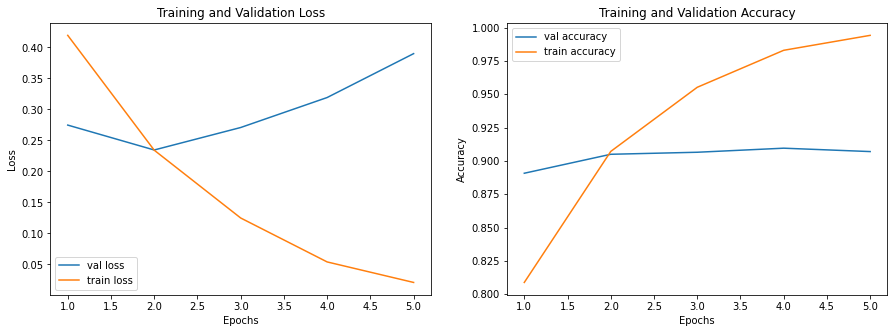

time: 33min 32s (started: 2021-05-16 16:05:47 +00:00)


In [24]:
history_tl = main(datasets, training_args_tl, config_ori, non_label_column_names, PRETRAINED_MODEL)

In [26]:
history_tl.model.summary()

Model: "tf_albert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  11683584  
_________________________________________________________________
dropout_14 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 11,685,122
Trainable params: 11,685,122
Non-trainable params: 0
_________________________________________________________________
time: 7.19 ms (started: 2021-05-16 16:40:33 +00:00)


# **Fine Tuning (Transfer Learning with some Changes on Architecture)**

Try to reduce:
* num_hidden_layers
* num_attention_heads

In [27]:
training_args_ft = TFTrainingArguments(
    output_dir=PROJECT_ROOT + 'results/hs/albert/fine-tuning/',         # output directory
    do_train=True,
    do_predict=True,
    do_eval=True,
    num_train_epochs=25,                                                # total number of training epochs
    per_device_train_batch_size=16,                                     # batch size per device during training
    per_device_eval_batch_size=16,                                      # batch size for evaluation
    learning_rate=4e-5,
    max_grad_norm=10,
    seed=42
)

time: 6.65 ms (started: 2021-05-16 16:43:16 +00:00)


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['sop_classifier']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25
574/574 [==============================] - 275s 463ms/step - loss: 0.5111 - accuracy: 0.7358 - val_loss: 0.2431 - val_accuracy: 0.9070
Epoch 2/25
574/574 [==============================] - 267s 465ms/step - loss: 0.2371 - accuracy: 0.9066 - val_loss: 0.2413 - val_accuracy: 0.9014
Epoch 3/25
574/574 [==============================] - 268s 467ms/step - loss: 0.1378 - accuracy: 0.9476 - val_loss: 0.2414 - val_accuracy: 0.9141
Epoch 4/25
574/574 [==============================] - 268s 467ms/step - loss: 0.0911 - accuracy: 0.9680 - val_loss: 0.2838 - val_accuracy: 0.9035
Epoch 5/25
574/574 [==============================] - 267s 464ms/step - loss: 0.0598 - accuracy: 0.9780 - val_loss: 0.3512 - val_accuracy: 0.8928


============================== MODEL PERFORMANCE ON TEST SET ===============================
Loss:0.3680 ACC:0.8959 F1:0.8950 REC:0.8959 PRE:0.8976

Classification Report:
              precision    recall  f1-score   support

          hs       0.88      0.95      0.

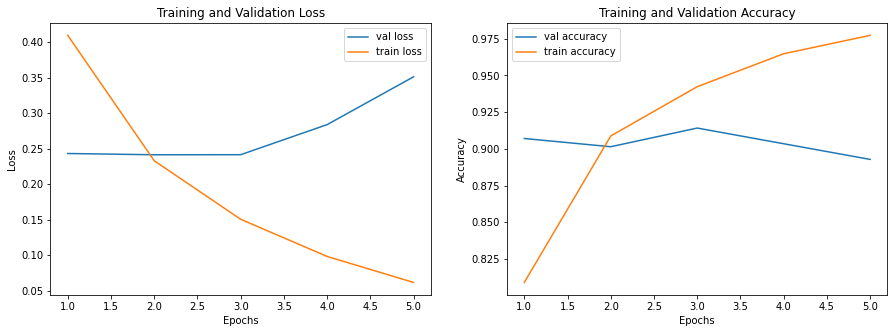

time: 22min 53s (started: 2021-05-16 16:43:17 +00:00)


In [28]:
history_ft = main(datasets, training_args_ft, config_ft, non_label_column_names, PRETRAINED_MODEL)

In [29]:
history_ft.model.summary()

Model: "tf_albert_for_sequence_classification_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  11683584  
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 11,685,122
Trainable params: 11,685,122
Non-trainable params: 0
_________________________________________________________________
time: 4.56 ms (started: 2021-05-16 17:09:38 +00:00)


In [ ]:
# https://stackoverflow.com/questions/67052427/how-to-access-a-particular-layer-of-huggingfaces-pre-trained-bert-model
history_ft.model.layers[0].embeddings

time: 3.58 ms (started: 2021-05-15 22:27:07 +00:00)


# **Test on Some Instances**

## **Preprocess emoji and emoticon**

The preprocessing functions are copied from [hate speech preprocessing notebook](https://github.com/thingkilia2507/PTCJNN_BangkitCapstoneProject/blob/celine-branch/Machine%20Learning/notebooks/Hate%20Speech%20Dataset%20Preprocessing.ipynb) which was used to preprocess the training data.

In [33]:
with open('EMOTICONS_ID.json') as f:
    EMOTICONS_ID = json.load(f)

with open('EMOJI_ID.json') as f:
    EMOJI_ID = json.load(f)

time: 11.3 ms (started: 2021-05-16 17:17:00 +00:00)


In [44]:
def emot_to_desc(tweet):
    # Regex punctuation nya diperoleh dari `string.punctuation` dan ditambahkan `“”…`
    rgx_repeated_punct = re.compile(r'''([!"#$%&'()*+,-./:;<=>?@[\]^_`“”{|}~…])\1+''', re.IGNORECASE)
    tweet = re.sub(rgx_repeated_punct, r'\1', tweet)                                # remove repeated punctuation, e.g. :---))))))))

    for emot in EMOTICONS_ID:
        tweet = re.sub('(' + emot + ')', ' '.join(EMOTICONS_ID[emot].replace(',', '').split()), tweet)
    
    return tweet


# Use code from https://github.com/carpedm20/emoji/blob/master/emoji/core.py and modified accordingly.
# Returns compiled regular expression that matches emojis defined in
# ``EMOJI_ID``. The regular expression is only compiled once.
def get_emoji_regexp():
    EMOJI_UNICODE = EMOJI_ID
    
    # Sort emojis by length to make sure multi-character emojis are matched first
    emojis = sorted(EMOJI_UNICODE.keys(), key=len, reverse=True)

    # Escape Unicode string
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'

    # combine a regular expression pattern into pattern objects, which can be used for pattern matching
    _EMOJI_REGEXP = re.compile(pattern)

    return _EMOJI_REGEXP


_EMOJI_REGEXP = get_emoji_regexp()
_DEFAULT_DELIMITER = ':'
# Returns emoji that has been replaced by its decriptions in Bahasa Indonesia
def emoji_to_desc(string, delimiters=(_DEFAULT_DELIMITER, _DEFAULT_DELIMITER), codes_dict=EMOJI_ID):
    def replace(match):
        val = codes_dict.get(match.group(0), match.group(0))
        return delimiters[0] + val[1:-1] + delimiters[1]

    demojized = _EMOJI_REGEXP.sub(replace, string)
    return re.sub(u'\ufe0f', '', demojized)


def clean(text):
    punct = '''([!"#$%&'()*+,-./:;=?@[\]^_`“”{|}~…])\1+'''                                 # from string.punctuation but without <>
    rgx_multi_space = r' {2,}'
    rgx_byte_format = r'''b'|b"'''

    text = text.lower()
    cleansed = re.sub(rgx_byte_format, '', text)
    cleansed = cleansed.translate(str.maketrans(punct, ' '*len(punct)))                    # replace punct with whitespace
    cleansed = re.sub(rgx_multi_space, ' ', cleansed)                                      # remove multiple spaces
    cleansed = cleansed.strip()                                                            # remove trailing spaces
    return cleansed

time: 38.8 ms (started: 2021-05-16 17:37:10 +00:00)


In [45]:
list_text = ['Dia ngatain aku jelek 😢',
             'Aku dipukul sama dia :(',
             'Aku cape dimarahin terus. Ga ngerti lagi deh sama orang ky dia',
             'Ga ngerti lagi deh sama orang ky dia 🙄',
             'Eh bego lu, mending mati aja sana',
             'Ngapain sih chat di sini, tukang ngadu dasar']

texts_emot_desc = [emot_to_desc(text) for text in list_text]
texts_emoji_emot_desc = [emoji_to_desc(text) for text in texts_emot_desc]
preprocessed_texts = [clean(text) for text in texts_emoji_emot_desc]

time: 14 ms (started: 2021-05-16 17:37:55 +00:00)


In [41]:
texts_emot_desc

['Dia ngatain aku jelek 😢',
 'Aku dipukul sama dia sedih atau cemberut',
 'Aku cape dimarahin terus. Ga ngerti lagi deh sama orang ky dia',
 'Ga ngerti lagi deh sama orang ky dia 🙄',
 'Eh bego lu, mending mati aja sana',
 'Ngapain sih chat di sini, tukang ngadu dasar']

time: 2.34 ms (started: 2021-05-16 17:23:32 +00:00)


In [42]:
texts_emoji_emot_desc

['Dia ngatain aku jelek :menangis:',
 'Aku dipukul sama dia sedih atau cemberut',
 'Aku cape dimarahin terus. Ga ngerti lagi deh sama orang ky dia',
 'Ga ngerti lagi deh sama orang ky dia :wajah dengan mata berputar:',
 'Eh bego lu, mending mati aja sana',
 'Ngapain sih chat di sini, tukang ngadu dasar']

time: 3.43 ms (started: 2021-05-16 17:23:34 +00:00)


In [46]:
preprocessed_texts

['dia ngatain aku jelek menangis',
 'aku dipukul sama dia sedih atau cemberut',
 'aku cape dimarahin terus ga ngerti lagi deh sama orang ky dia',
 'ga ngerti lagi deh sama orang ky dia wajah dengan mata berputar',
 'eh bego lu mending mati aja sana',
 'ngapain sih chat di sini tukang ngadu dasar']

time: 3.77 ms (started: 2021-05-16 17:38:07 +00:00)


## **Predict**

In [30]:
ori_model = TFAlbertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, config=config_ori)
tl_model = TFAlbertForSequenceClassification.from_pretrained(PROJECT_ROOT + 'results/hs/albert/transfer-learning')
ft_model = TFAlbertForSequenceClassification.from_pretrained(PROJECT_ROOT + 'results/hs/albert/fine-tuning')

dict_model = {'Original Pre-trained Model': ori_model,
              'Transfer Learning Model': tl_model,
              'Transfer Learning with Fine Tuning Model': ft_model}

Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['sop_classifier']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some layers from the model checkpoint at drive/M

time: 3.86 s (started: 2021-05-16 17:10:22 +00:00)


In [47]:
for desc, model in dict_model.items():
  print(f'\n\033[1mHasil Prediksi menggunakan {desc}:\033[0m')
  for text in preprocessed_texts:
      subwords = tokenizer(text, return_tensors='tf')
      predictions = model(subwords)['logits']
      predicted_class_idx = np.argmax(predictions, axis=1)[0]
      predicted_class_label = config_ft.id2label[predicted_class_idx]
      print(f'Kalimat "\033[1m{text}\033[0m" diprediksi sebagai label \033[1m{predicted_class_label}\033[0m')


Hasil Prediksi menggunakan Original Pre-trained Model:
Kalimat "dia ngatain aku jelek menangis" diprediksi sebagai label hs
Kalimat "aku dipukul sama dia sedih atau cemberut" diprediksi sebagai label non_hs
Kalimat "aku cape dimarahin terus ga ngerti lagi deh sama orang ky dia" diprediksi sebagai label non_hs
Kalimat "ga ngerti lagi deh sama orang ky dia wajah dengan mata berputar" diprediksi sebagai label non_hs
Kalimat "eh bego lu mending mati aja sana" diprediksi sebagai label non_hs
Kalimat "ngapain sih chat di sini tukang ngadu dasar" diprediksi sebagai label hs

Hasil Prediksi menggunakan Transfer Learning Model:
Kalimat "dia ngatain aku jelek menangis" diprediksi sebagai label hs
Kalimat "aku dipukul sama dia sedih atau cemberut" diprediksi sebagai label non_hs
Kalimat "aku cape dimarahin terus ga ngerti lagi deh sama orang ky dia" diprediksi sebagai label non_hs
Kalimat "ga ngerti lagi deh sama orang ky dia wajah dengan mata berputar" diprediksi sebagai label non_hs
Kalimat "e